In [23]:
from preprocessor import Preprocessor



from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer


'''
Load some data and do some cleaning
'''
crimes = pd.read_csv("~/Documents/datasets/crime.csv",nrows = 100000)

#crimes['Mapping'] = np.abs(crimes["X"] + crimes["Y"]) 
crimes.drop(['IncidntNum','Descript','Location'],1,inplace=True)
crimes.shape

(100000, 10)

In [6]:



# custom multicolumn transformer

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode
        
    def fit(self, X,y=None):
        return self # not relevant
    def transform(self, X):
        ''' 
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all columns in X
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
             for colname,col in enumerate(output):
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    
    def fit_transform(self, X ,y=None):
        return self.fit(X,y).transform(X)
    
### you can also use the above class as shown in the line below ###
#MultiColumnLabelEncoder(columns = cat_attributes).fit_transform(olympics)
                    
def column_types(df):
    cat_cols = []
    num_cols = []
    
    for y in df.columns:
        if (df[y].dtype == object):
            cat_cols.append(y)
        else:
            num_cols.append(y)
    
    return cat_cols, num_cols

# Handling categorical attributes
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

class MyLabelBinarizer():
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer( *args, **kwargs)
    def fit(self, x, y = 0):
        self.encoder.fit(x)
        return self
    def transform(self,x, y=0):
        return self.encoder.transform(x)

cat_attributes ,num_attributes = column_types(crimes)

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_encoder', MultiColumnLabelEncoder())
]) 

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

prepared = full_pipeline.fit_transform(crimes)

labels = crimes["Category"]

X_train, X_test, y_train ,y_test = train_test_split(prepared, labels, random_state= 0,test_size = 0.25)
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
label_rf = forest.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


Accuracy on the training subset: 0.961067
Accuracy on the testing subset: 0.582356


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


'''
Load some data and do some cleaning
#NOTE: This dataset contains one million rows so it takes a considerable time 
        to load depending on your computing power and memory resources
'''
data = pd.read_csv('~/Documents/datasets/crime.csv',nrows=100000)

data = data.sample(frac=0.05, random_state=1)
to_drop = ['IncidntNum','Category','PdId']
X_all = data.drop(to_drop,1)
y_all = data["Category"]


#Standardising the data
num_features = ['X','Y']
cat_features = ['Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution',
       'Address', 'Location']

scaled_data = StandardScaler().fit_transform(X_all[num_features])
scaled = pd.DataFrame(scaled_data,columns = num_features)
dummies = pd.get_dummies(X_all[cat_features],prefix = [col for col, col_data in X_all[cat_features].iteritems()])


len(cat_features)

pca=PCA(n_components=300)

x_pca = pca.fit_transform(dummies)
x_pca = pd.DataFrame(x_pca)

df = x_pca.join(scaled)

X_train, X_test, y_train ,y_test = train_test_split(df, y_all, random_state= 0,test_size = 0.25)
pca.explained_variance_ratio_.sum()

0.6168819125095479

In [18]:
x_pca.shape

(5000, 300)

In [19]:
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
label_rf = forest.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


Accuracy on the training subset: 0.999733
Accuracy on the testing subset: 0.820800


In [25]:
%matplotlib inline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score


clf_A = LogisticRegression(solver='lbfgs',random_state = 42,multi_class='auto')
clf_B = SVC(random_state = 912,kernel = 'rbf',gamma = 'scale')
clf_C = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state=82)
clf_D = xgb.XGBClassifier(seed=82)

print('Logistic Regresssion...')
start  = time()
clf_A.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_A = clf_A.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_A,average = 'macro')))
#print(classification_report(y_test,y_pred_A))
print('Accuracy on the training subset: {:3f}'.format(clf_A.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_A.score(X_test, y_test)))
print('')

print('Support Vector Machine...')
start  = time()
clf_B.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_B = clf_B.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_B,average = 'macro')))
print('Accuracy on the training subset: {:3f}'.format(clf_B.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_B.score(X_test, y_test)))
print('')

print('Random Forest...')
start = time()
clf_C.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_C = clf_C.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_C,average = 'macro')))
#print(classification_report(y_all,y_pred_C))
print('Accuracy on the training subset: {:3f}'.format(clf_C.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_C.score(X_test, y_test)))
print('')


Logistic Regresssion...
Done in 1.1359312534332275 seconds...
F1 Score: 0.5866798620453872
Accuracy on the training subset: 0.946933
Accuracy on the testing subset: 0.880000

Support Vector Machine...
Done in 7.899817228317261 seconds...
F1 Score: 0.3841930141444428
Accuracy on the training subset: 0.777867
Accuracy on the testing subset: 0.750400

Random Forest...
Done in 5.501576900482178 seconds...
F1 Score: 0.3776216671420007
Accuracy on the training subset: 0.800533
Accuracy on the testing subset: 0.746400



In [4]:
import dateutil
from matplotlib import style
style.use('ggplot')

data = pd.read_csv('~/Documents/datasets/crime.csv',nrows=100000)
data['Date'] = data['Date'].apply(dateutil.parser.parse, dayfirst=True)
data['Month'] = data['Date'].apply(lambda x: x.month)
data.dtypes

IncidntNum             int64
Category              object
Descript              object
DayOfWeek             object
Date          datetime64[ns]
Time                  object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Location              object
PdId                   int64
Month                  int64
dtype: object

In [5]:
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import calendar
import seaborn as sns

data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Month
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000,Jan
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074,Jan
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014,Jan
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200,Jan
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160,Jan


In [6]:
data['PdDistrict'].unique()
#x = pd.DataFrame()
group_by_day = data.groupby(['DayOfWeek','PdDistrict'])
count_group_by_day = group_by_day.size().unstack()
count_group_by_day
# do a heatmap of day of week and crime in different districts
#use the dateutils lib to properly parse dates and times

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
DayOfWeek,,,,,,,,,,
Friday,1482,1740,1210,2079,2065,936,833,2961,1011,1111
Monday,1362,1495,1192,1785,1813,858,677,2469,978,1177
Saturday,1368,1968,1254,1956,1999,836,750,2938,947,1117
Sunday,1259,1581,1054,1845,1820,848,760,2376,815,988
Thursday,1286,1533,1205,1950,1758,880,781,2583,914,1131
Tuesday,1294,1466,1187,1829,1742,827,705,2548,929,1163
Wednesday,1404,1604,1228,1997,1752,875,756,2672,1036,1252


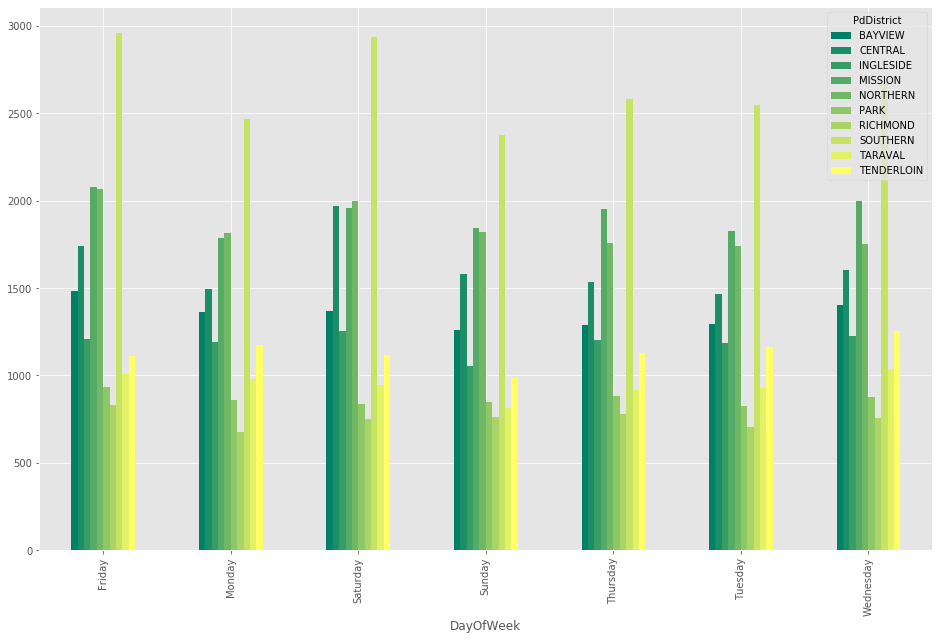

In [7]:
count_group_by_day.plot(kind='bar', figsize=[16,10],colormap='summer')
plt.show()

In [8]:
data['Category'].value_counts()


LARCENY/THEFT                  25805
OTHER OFFENSES                 15250
NON-CRIMINAL                   11626
ASSAULT                         7610
VEHICLE THEFT                   5477
WARRANTS                        5112
VANDALISM                       4816
DRUG/NARCOTIC                   4366
BURGLARY                        3501
ROBBERY                         2841
MISSING PERSON                  2816
SUSPICIOUS OCC                  2428
FRAUD                           1926
SECONDARY CODES                 1343
WEAPON LAWS                      949
TRESPASS                         696
DRUNKENNESS                      473
SEX OFFENSES, FORCIBLE           450
FORGERY/COUNTERFEITING           393
DRIVING UNDER THE INFLUENCE      367
KIDNAPPING                       338
DISORDERLY CONDUCT               272
ARSON                            196
STOLEN PROPERTY                  168
PROSTITUTION                     166
RECOVERED VEHICLE                134
LIQUOR LAWS                      130
R

In [9]:
data['Resolution'].value_counts()

NONE                                      62752
ARREST, BOOKED                            22796
ARREST, CITED                              7921
PSYCHOPATHIC CASE                          2412
LOCATED                                    1689
UNFOUNDED                                   890
JUVENILE BOOKED                             650
JUVENILE CITED                              249
EXCEPTIONAL CLEARANCE                       221
COMPLAINANT REFUSES TO PROSECUTE            144
JUVENILE ADMONISHED                          76
CLEARED-CONTACT JUVENILE FOR MORE INFO       50
PROSECUTED BY OUTSIDE AGENCY                 49
NOT PROSECUTED                               40
DISTRICT ATTORNEY REFUSES TO PROSECUTE       36
JUVENILE DIVERTED                            25
Name: Resolution, dtype: int64

In [10]:
crimes_by_district = data.pivot_table(index='Date', columns='PdDistrict', values='IncidntNum', aggfunc='count')
crimes_by_district.head(20)


PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Date,,,,,,,,,,
2014-01-01,44.0,65.0,19.0,54.0,50.0,10.0,27.0,57.0,36.0,34.0
2014-01-02,48.0,45.0,36.0,45.0,50.0,18.0,17.0,83.0,31.0,27.0
2014-01-03,38.0,47.0,34.0,59.0,44.0,16.0,21.0,61.0,31.0,28.0
2014-01-04,39.0,29.0,28.0,48.0,37.0,26.0,19.0,55.0,28.0,25.0
2014-01-05,46.0,31.0,28.0,53.0,47.0,22.0,15.0,62.0,31.0,23.0
2014-01-06,20.0,37.0,28.0,47.0,32.0,12.0,14.0,55.0,7.0,19.0
2014-01-07,23.0,11.0,13.0,11.0,14.0,10.0,5.0,22.0,3.0,10.0
2014-01-08,12.0,11.0,4.0,18.0,42.0,3.0,3.0,31.0,13.0,2.0
2014-01-09,7.0,14.0,1.0,11.0,27.0,10.0,6.0,19.0,13.0,7.0
